In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import neurokit2 as nk
from scipy import stats
from matplotlib.animation import FuncAnimation, FFMpegWriter
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

In [3]:
scaler = StandardScaler()



In [4]:
# load saved TensorFlow model
model_path = r"C:\Users\brook\Desktop\Descartes_Real_Time_Predictions\Mural_ECG_model\model"
model = tf.saved_model.load(model_path)


In [12]:
ecg_signal = []
t = []
t2 = []
t3 = []
hr_mean = []
snr_values = []
hr_max = []
hr_min = []
heart_rate_variability = []
t11= [] 
hr_features = []
predictions = []
frame_count = 0  # Initialize frame count

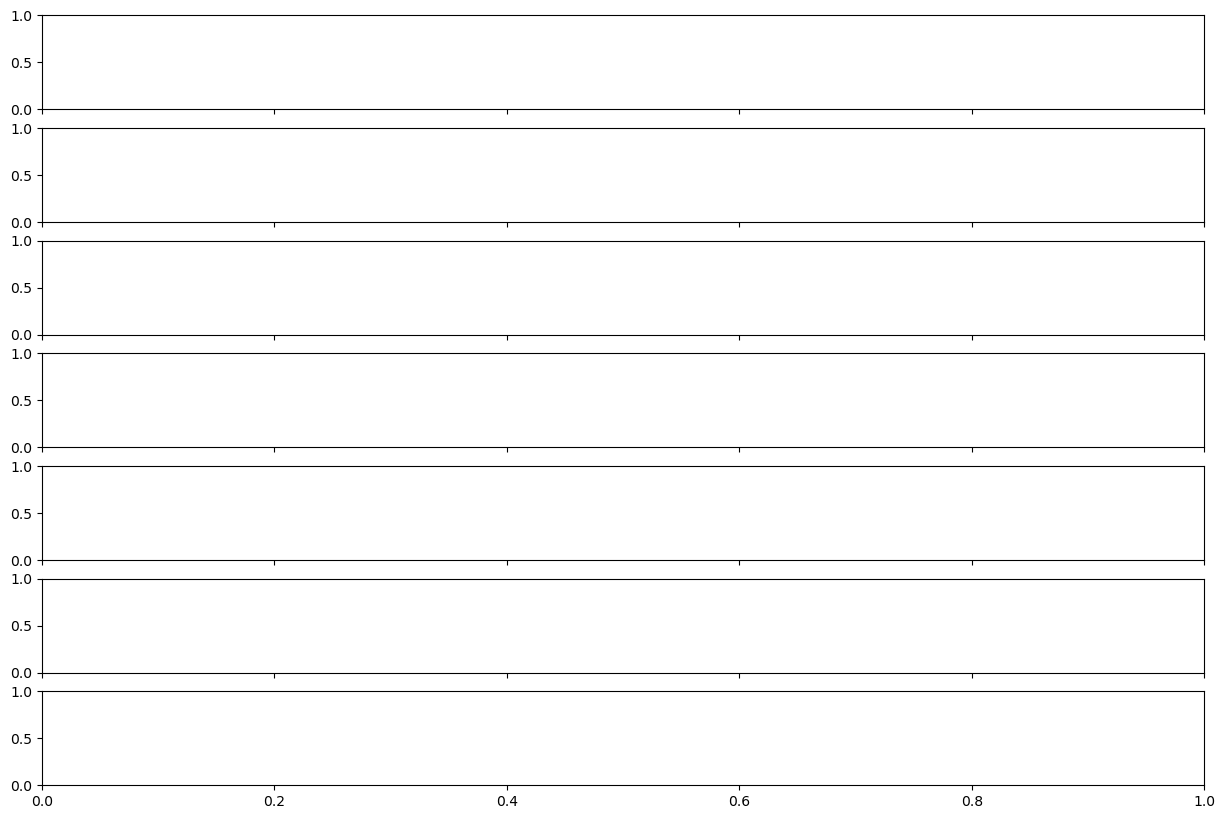

In [13]:
# Set animation parameters
num_frames = 1650
interval = 50  # milliseconds

# Set up plot
fig, axs = plt.subplots(7, 1, figsize=(15, 10), sharex=True)

# Create animation object
ani = animation.FuncAnimation(fig, animate, frames=num_frames, interval=interval, blit=False)

# Show the animation
plt.show()

# SNR

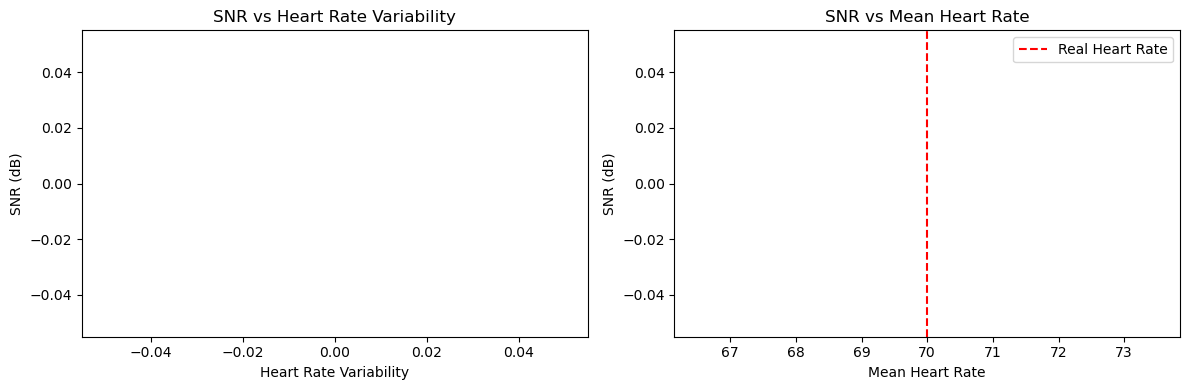

In [9]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first scatter plot on the left subplot (ax1)
ax1.scatter(heart_rate_variability, snr_values, color='purple', alpha=0.5)
ax1.set_title('SNR vs Heart Rate Variability')
ax1.set_xlabel('Heart Rate Variability')
ax1.set_ylabel('SNR (dB)')

# Plot the second scatter plot on the right subplot (ax2)
ax2.scatter(hr_mean, snr_values, color='purple', alpha=0.5)
ax2.set_title('SNR vs Mean Heart Rate')
ax2.set_xlabel('Mean Heart Rate')
ax2.set_ylabel('SNR (dB)')
# Add a vertical dashed line at x-axis value 70 with the label "Synaptic Heart Rate"
ax2.axvline(x=70, color='red', linestyle='--', label='Real Heart Rate')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot with two subplots
plt.show()

In [10]:
# Sample data (replace this with your actual data)
data = np.column_stack((hr_mean, heart_rate_variability, snr_values))

# Fit K-Means with only 2 clusters to exclude outliers
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
cluster_labels = kmeans.fit_predict(data)
cluster_centers = kmeans.cluster_centers_

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Heart Rate vs. SNR
ax1 = axes[0]
ax1.scatter(data[:, 0], data[:, 2], c=cluster_labels, cmap='viridis', s=100)
ax1.scatter(cluster_centers[:, 0], cluster_centers[:, 2], c='yellow', marker='*', s=300, edgecolors='black')
ax1.set_xlabel("Heart Rate")
ax1.set_ylabel("SNR")
ax1.set_title("Heart Rate vs. SNR")
ax1.grid(False)

# Add SNR values as text labels
for i, center in enumerate(cluster_centers):
    ax1.text(center[0], center[2], f"SNR {center[2]:.2f}", fontsize=12, ha='center', va='bottom', color='black')

# Plot 2: Heart Rate Variability vs. SNR
ax2 = axes[1]
ax2.scatter(data[:, 1], data[:, 2], c=cluster_labels, cmap='viridis', s=100)
ax2.scatter(cluster_centers[:, 1], cluster_centers[:, 2], c='yellow', marker='*', s=300, edgecolors='black')
ax2.set_xlabel("Heart Rate Variability")
ax2.set_ylabel("SNR")
ax2.set_title("Heart Rate Variability vs. SNR")
ax2.grid(False)

# Add SNR values as text labels
for i, center in enumerate(cluster_centers):
    ax2.text(center[1], center[2], f"SNR {center[2]:.2f}", fontsize=12, ha='center', va='bottom', color='black')

# Show the plots
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by KMeans.

NameError: name 'cluster_probs' is not defined

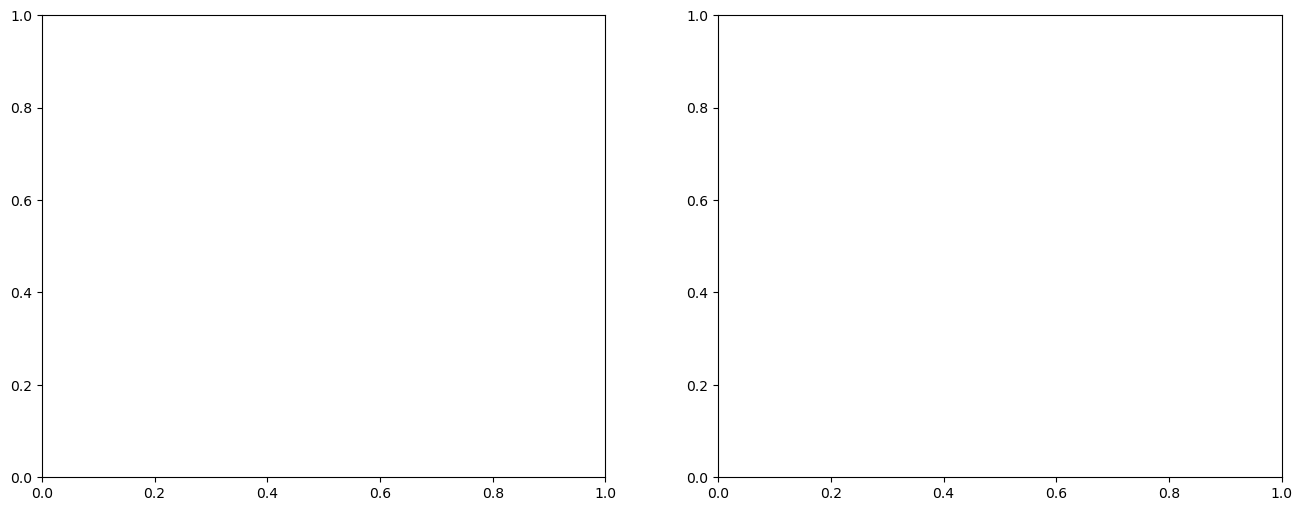

In [16]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Heart Rate vs. SNR
ax1 = axes[0]
ax1.scatter(data[:, 0], data[:, 2], c=cluster_probs[:, 0], cmap='viridis', s=100, alpha=0.5)
ax1.scatter(cluster_centers[:, 0], cluster_centers[:, 2], c='yellow', marker='*', s=300, edgecolors='black')
ax1.set_xlabel("Heart Rate")
ax1.set_ylabel("SNR")
ax1.set_title("Heart Rate vs. SNR")
ax1.grid(False)

# Add SNR values as text labels
for i, center in enumerate(cluster_centers):
    ax1.text(center[0], center[2], f"SNR {center[2]:.2f}", fontsize=12, ha='center', va='bottom', color='black')

# Plot 2: Heart Rate Variability vs. SNR
ax2 = axes[1]
ax2.scatter(data[:, 1], data[:, 2], c=cluster_probs[:, 0], cmap='viridis', s=100, alpha=0.5)
ax2.scatter(cluster_centers[:, 1], cluster_centers[:, 2], c='yellow', marker='*', s=300, edgecolors='black')
ax2.set_xlabel("Heart Rate Variability")
ax2.set_ylabel("SNR")
ax2.set_title("Heart Rate Variability vs. SNR")
ax2.grid(False)

# Add SNR values as text labels
for i, center in enumerate(cluster_centers):
    ax2.text(center[1], center[2], f"SNR {center[2]:.2f}", fontsize=12, ha='center', va='bottom', color='black')

# Show the plots
plt.show()


In [14]:
def get_ecg_features(ecg, time_in_sec, fs):
    """
    Compute ECG features from raw ECG signal.

    Parameters
    ----------
    ecg : array-like
        Raw ECG signal.
    time_in_sec : array-like
        Timestamps corresponding to each sample of the ECG signal.
    fs : float
        Sampling frequency of the ECG signal.

    Returns
    -------
    array
        Array of ECG features: [mean heart rate, maximum heart rate, minimum heart rate, heart rate variability].
    """
    try:
        b, a = butter(4, (0.25, 25), 'bandpass', fs=fs)
        ecg_filt = filtfilt(b, a, ecg, axis=0)
        ecg_cleaned = nk.ecg_clean(ecg_filt, sampling_rate=fs)
        instant_peaks, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs,method="engzeemod2012")
    except Exception as e:
        raise ValueError("Error processing ECG signal: " + str(e))

    rr_times = time_in_sec[rpeaks['ECG_R_Peaks']]
    if len(rr_times) == 0:
        raise ValueError("No R-peaks detected in ECG signal.")
    
    # Assuming d_rr contains the time intervals between successive heartbeats in seconds
    d_rr = np.diff(rr_times)
    heart_rate = 60 / d_rr
    if heart_rate.size == 0:
        raise ValueError("Error computing heart rate from ECG signal.")
    
    valid_heart_rate = heart_rate[~np.isnan(heart_rate)]
    z_scores = np.abs(stats.zscore(valid_heart_rate))

    # Define a z-score threshold beyond which a value is considered an outlier
    z_score_threshold = 2.0

    # Remove outliers from the valid_heart_rate array
    heart_rate = valid_heart_rate[z_scores <= z_score_threshold]

    hr_mean = np.nanmean(heart_rate)
    hr_min = np.nanmin(heart_rate)
    hr_max = np.nanmax(heart_rate)
    d_rr_ms = 1000 * d_rr
    d_d_rr_ms = np.diff(d_rr_ms)

    valid_d_d_rr_ms = d_d_rr_ms[~np.isnan(d_d_rr_ms)] 
    z_scores = np.abs(stats.zscore(valid_d_d_rr_ms))
    d_d_rr_ms= valid_d_d_rr_ms[z_scores <= z_score_threshold]
    heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))

    # Create a new signal 'ecg_with_rr_intervals' with RR intervals and a 1-second window around each RR interval
    ecg_with_rr_intervals = []
    ecg_with_rr_intervals_cleaned = []

    for rr_interval in rr_times:
        start_time = rr_interval - 0.2  # 1 second before the RR interval
        end_time = rr_interval + 0.2    # 1 second after the RR interval
        indices = np.where((time_in_sec >= start_time) & (time_in_sec <= end_time))[0]

        # Validate indices to ensure they are within bounds
        indices = indices[(indices >= 0) & (indices < len(ecg))]

        if len(indices) > 0:
            ecg_with_rr_intervals.extend(ecg[indices])
            ecg_with_rr_intervals_cleaned.extend(ecg_cleaned[indices])

    # Convert lists to NumPy arrays
    ecg_with_rr_intervals = np.array(ecg_with_rr_intervals)
    ecg_with_rr_intervals_cleaned = np.array(ecg_with_rr_intervals_cleaned)

    # Calculate noise power (mean squared amplitude of noise)
    signal_power = np.var(ecg_with_rr_intervals)
    noise_power = np.var(ecg_with_rr_intervals - ecg_with_rr_intervals_cleaned)

    # Calculate noise power (mean squared amplitude of noise)
    #signal_power = np.var(ecg)
    #noise_power = np.var(ecg - ecg_cleaned)

     # Calculate SNR in dB and append it to the array
    snr_values = 10 * np.log10(signal_power / noise_power)
    
    return np.array([hr_mean, hr_max, hr_min, heart_rate_variability, snr_values])

In [15]:
def animate(i):
    global ecg_signal, t, hr_mean, hr_max, hr_min, heart_rate_variability, snr_values, t2, t3, predictions, frame_count

    # Check if 200 frames have been processed
    if frame_count >= 1650:
        return
    
    # Set sampling rate and duration
    fs = 250
    duration = 15  # seconds
    t += list(np.arange(i, i+duration, 1/fs))
    #t11 = np.arange(i, i+10000, 1/fs)

    # Compute ECG features
    window_shift = 1
    window_size = 30
    
    #ecg_signal += list(nk.ecg_simulate(duration, sampling_rate=fs, heart_rate=70, noise=2)) # Real Time DATA
    ecg_signal = nk.ecg_simulate(duration, sampling_rate=fs, heart_rate=70)

    # Define noise levels for each set of 75 frames
    if frame_count < 200:
        noise_std = 0.01
    elif frame_count < 450:
        noise_std = 0.05
    elif frame_count < 650:
        noise_std = 0.175
    elif frame_count < 850:
        noise_std = 0.175
    elif frame_count < 1150:
        noise_std = 0.2
    elif frame_count < 1350:
        noise_std = 0.5
    elif frame_count < 1450:
        noise_std = 0.75
    elif frame_count < 1550:
        noise_std = 1
    else:
        noise_std = 0.85

    # Generate noise with the specified standard deviation
    higher_freq_noise = np.random.normal(0, noise_std, len(ecg_signal))

    # Add the higher-frequency noise to the ECG signal
    ecg_signal= ecg_signal + higher_freq_noise

    # Get start and end index for current animation frame
    start_idx = int(i*window_shift*fs)
    end_idx = start_idx + window_size*fs

    #axs[0].clear()
    axs[0].plot(t[-window_shift*fs:], ecg_signal[-window_shift*fs:], color='black')
    #axs[0].plot(t11[-duration*window_size*fs:], ecg_signal[-duration*window_size*fs:], color='black')
    axs[0].set_title('ECG Signal')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Amplitude (mV)')


    if t[-1]>=30:

        hr_mean += [get_ecg_features(ecg_signal[-1*window_size*fs:], np.arange(start_idx, end_idx)/fs,fs=fs)[0]]
        hr_max += [get_ecg_features(ecg_signal[-1*window_size*fs:], np.arange(start_idx, end_idx)/fs,fs=fs)[1]]
        hr_min += [get_ecg_features(ecg_signal[-1*window_size*fs:], np.arange(start_idx, end_idx)/fs,fs=fs)[2]]
        heart_rate_variability += [get_ecg_features(ecg_signal[-1*window_size*fs:], np.arange(start_idx, end_idx)/fs,fs=fs)[3]]
        snr_values += [get_ecg_features(ecg_signal[-1*window_size*fs:], np.arange(start_idx, end_idx)/fs,fs=fs)[4]]
        
        #hr_min = process_ecg(ecg_signal, window_size, window_shift, fs)[0,1]
        #hr_max = process_ecg(ecg_signal, window_size, window_shift, fs)[0,2]
        #hr_variability = process_ecg(ecg_signal,window_size,window_shift,fs)[0,3]
        t2 += [np.round(np.max(t))]
        # Plot HR Mean for current frame
        #axs[1].clear()
        axs[2].plot(t2, hr_mean, color='blue')
        axs[2].set_title('HR Mean')
        axs[2].set_xlabel('Time (s)')
        axs[2].set_ylabel('HR Mean (BPM)')  

        axs[3].plot(t2, hr_max, color='red')
        axs[3].set_title('HR Max')
        axs[3].set_xlabel('Time (s)')
        axs[3].set_ylabel('HR Max (BPM)')  

        axs[4].plot(t2, hr_min, color='green')
        axs[4].set_title('HR Min')
        axs[4].set_xlabel('Time (s)')
        axs[4].set_ylabel('HR Min (BPM)')  

        axs[5].plot(t2, heart_rate_variability, color='black')
        axs[5].set_title('HR Variability')
        axs[5].set_xlabel('Time (s)')
        axs[5].set_ylabel('HR Variability (BPM)')  

        # Plot SNR on the 6th subplot (axes 5)
        axs[1].clear()
        axs[1].plot(t2, snr_values, color='purple')
        axs[1].set_title('SNR')
        axs[1].set_xlabel('Time (s)')
        axs[1].set_ylabel('SNR (dB)')
        
        # Set y-axis limits for the SNR plot
        axs[1].set_ylim(0, 15)
        # Increment frame count
        frame_count += 1

        if len(hr_mean) >= 30:
            hr_data = np.array([hr_mean, hr_max, hr_min, heart_rate_variability])
            # Standardize the heart rate data
            hr_data_std = scaler.fit_transform(hr_data.T)
            t3.append(np.round(np.max(t2)))
            # Get the standardized features for the current time
            current_features_std = hr_data_std[-1]
            # Make a prediction using the model
            prediction = model(current_features_std.reshape(1, -1))
            predictions.append(prediction[0][0])
            predictions_array = np.array(predictions)

            # Plot Probability and shaded area
            axs[6].clear()
            axs[6].plot(t3, predictions_array, color='black')
            #axs[5].plot(t3, predictions_array, color='black')
            axs[6].set_title('Probability')
            axs[6].set_xlabel('Time (s)')
            axs[6].set_ylabel('Probability')
            axs[6].axhline(y=0.5, linestyle='--', color='red')
            axs[6].set_ylim([0, 1])
            axs[6].fill_between(t3, predictions_array, where=(predictions_array >= 0.5), color='red', alpha=0.3, linewidth=2.5)

            
            #axs[5].fill_between(t3, predictions_array, where=(predictions_array >= 0.5), color='red', alpha=0.3, linewidth=2.5, step='post')
            
    plt.tight_layout()
    frame_count += 1  # Increment frame count